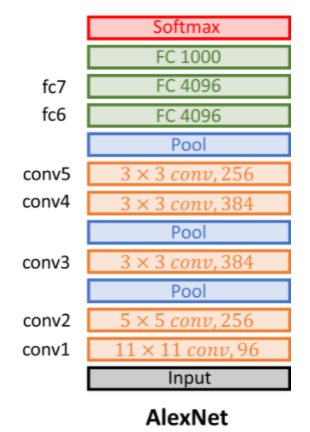  
Alexnet Architecture

## Cifar-10 Image Size => (32,32)
AlexNet basic Image size 3 227 227  
out image size so small => replace Kernel size 5,3

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

Calculation Channel  
(N - F) / Stride + 1

In [2]:
class AlexNet(nn.Module):
    
    def __init__(self):
        super(AlexNet,self).__init__()
        self.feature=nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1),# 64 30 30
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2),#MAXPooling 할 때 마지막 1은 버림. 64 27 27
        nn.Conv2d(64, 192, kernel_size=5, padding=2), # 192, 30, 30
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2), # 192 
        nn.Conv2d(192, 384, kernel_size=3, padding=1), # 384 
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1), # 256 
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2) # 256
        )
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        # 256 6 6 (6,6)은 output size이다.
        # 평균을 구하는 것으로 반올림 정수가 나옴.
        self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256*1*1,128),  # 9216=>4096, 256 36
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(128,128),
        nn.ReLU(inplace=True),
        nn.Linear(128,10), # => 10 class
        
        )
    def forward(self, x):
        x=self.feature(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1) # ex => 2,2,2 => 2,4
        x=self.classifier(x)
        return x

In [3]:
def dimension_check():
    net=AlexNet()
    x=torch.randn(1,3,32,32)
    y=net(x)
    print(y.size())

In [4]:
dimension_check()

torch.Size([1, 10])


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def train(net,partition,optimizer,criterion):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                             batch_size=128,
                                             shuffle=True)
    net.train()
    correct = 0
    total =0
    train_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        time.sleep(0.0000001)
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        #break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if i % 200 == 0:
        #    print(correct,train_loss)
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [8]:
def test(net, partition):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=128, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [9]:
def validate(net, partition, criterion):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=128, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in tqdm(valloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [10]:
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
import time

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
net=AlexNet()
net.cuda()
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0015, weight_decay=0.00001)
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
for epoch in range(5):
    ts=time.time()
    net, train_loss,train_acc=train(net, partition, optimizer, criterion)
    val_loss, val_acc = validate(net, partition, criterion)
    te=time.time()
    print('time : {:2.2f}, train_loss : {:2.2f}, train_acc : {:2.2f},val_acc : {:2.2f},val_loss : {:2.2f}'.format(te-ts,train_loss,train_acc,val_acc,val_loss))
    train_loss=round(train_loss,2)
    val_loss=round(val_loss,2)
    train_acc=round(train_acc,2)
    val_acc=round(val_acc,2)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
test_acc = test(net,partition)
test_acc=round(test_acc,2)

  1%|▏         | 4/313 [00:00<00:09, 32.31it/s]

time : 9.17, train_loss : 1.98, train_acc : 20.23,val_acc : 26.31,val_loss : 1.79


  1%|▏         | 4/313 [00:00<00:08, 35.58it/s]

time : 8.88, train_loss : 1.71, train_acc : 34.22,val_acc : 40.72,val_loss : 1.55


  1%|▏         | 4/313 [00:00<00:08, 36.77it/s]

time : 8.85, train_loss : 1.52, train_acc : 43.63,val_acc : 49.09,val_loss : 1.38


  1%|▏         | 4/313 [00:00<00:09, 32.44it/s]

time : 8.86, train_loss : 1.35, train_acc : 52.08,val_acc : 55.75,val_loss : 1.22


 63%|██████▎   | 196/313 [00:05<00:03, 38.54it/s]